# Building a table image to .csv pipeline

## Install libraries

In [8]:
%pip install transformers
%pip install pillow huggingface_hub
%pip install timm
%pip install matplotlib

## Table detection

What do you understand by table detection?

Definition: Given an image, finding the region of the table as a bounding box.

In [9]:
from huggingface_hub import hf_hub_download
from transformers import AutoImageProcessor, TableTransformerForObjectDetection
import torch
from PIL import Image

file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="example_pdf.png")
image = Image.open(file_path).convert("RGB")



Let's look at the page image

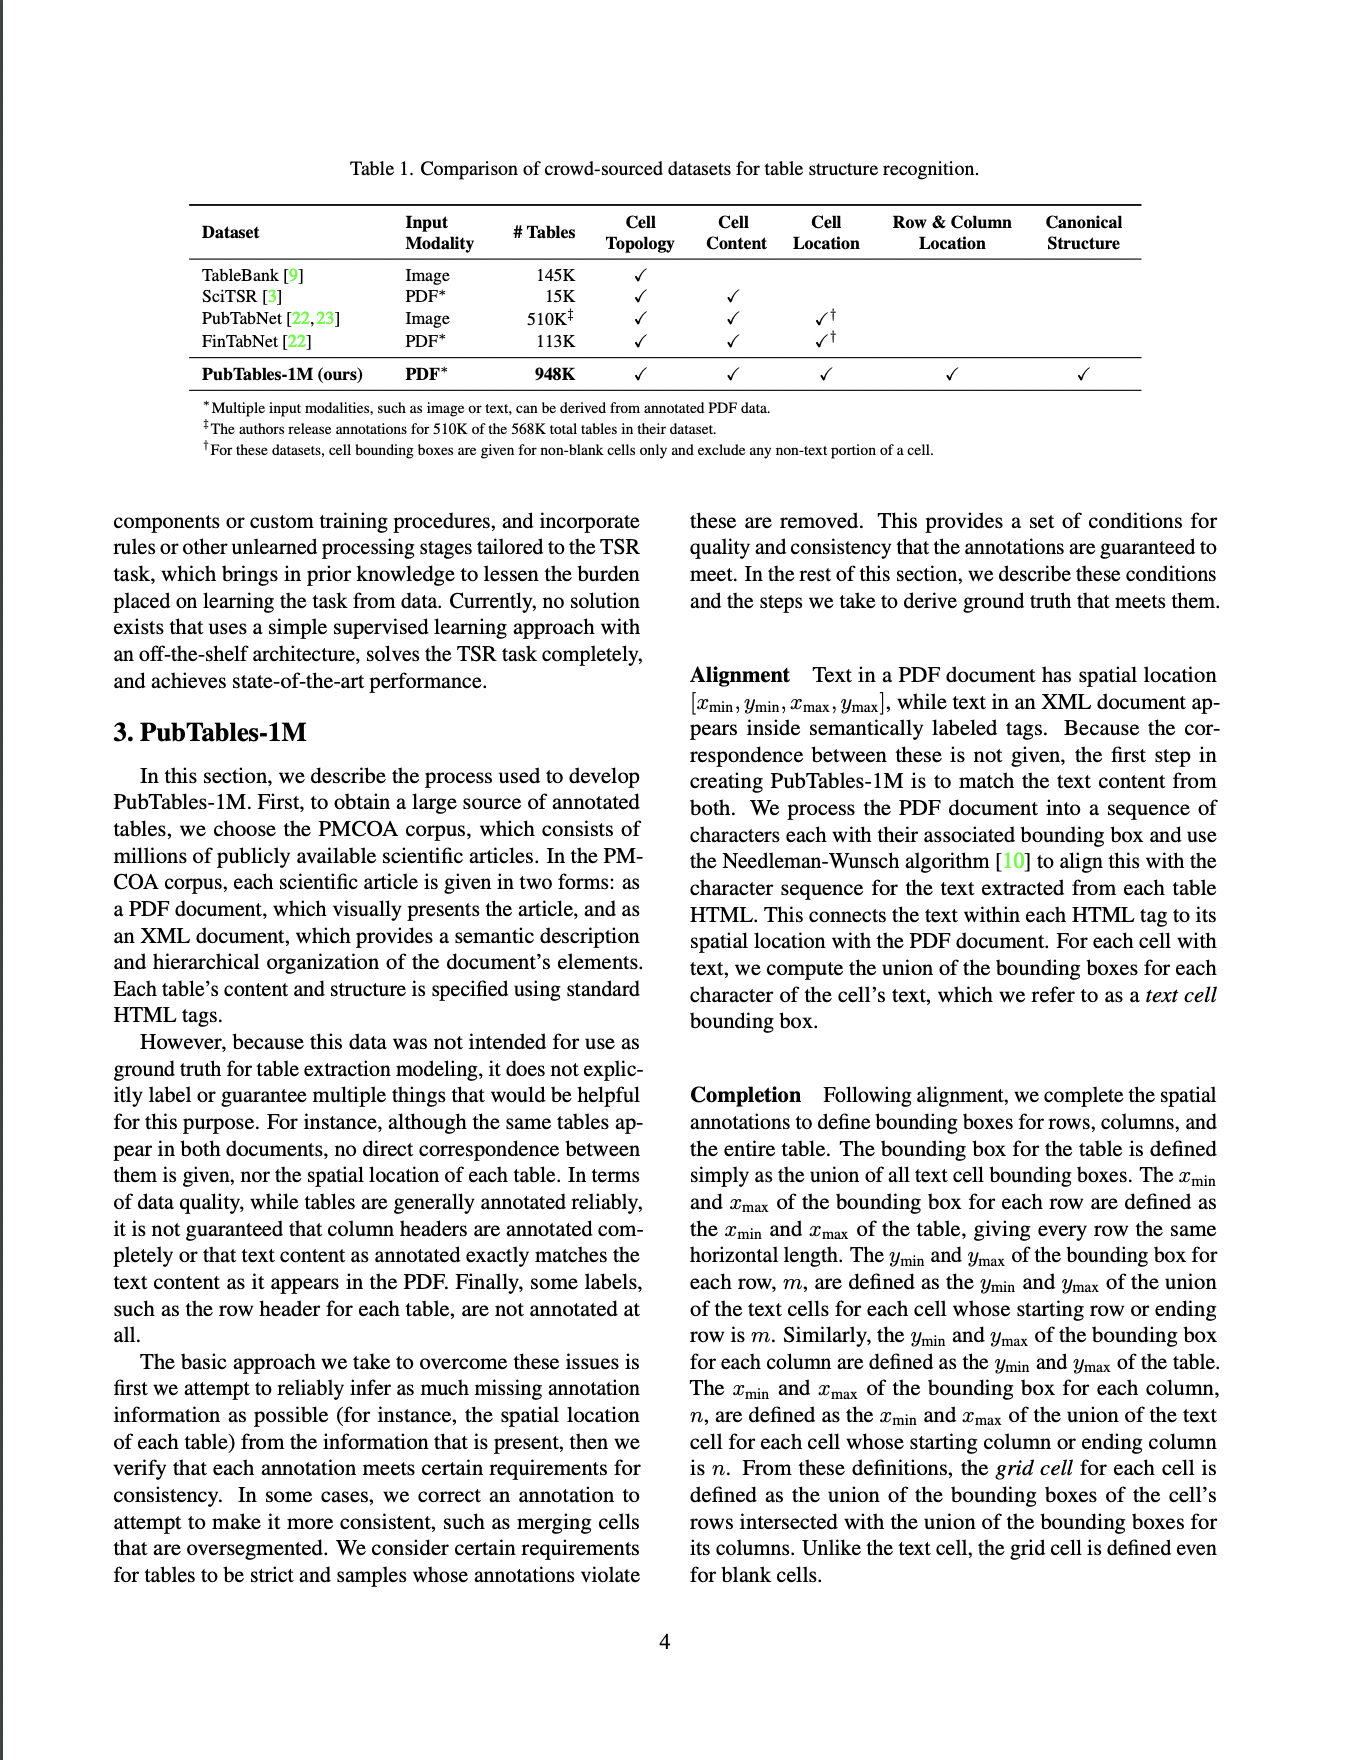

In [10]:
image

In [11]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/table-transformer-detection")
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[
    0
]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mo

Detected table with confidence 1.0 at location [202.02, 210.86, 1119.51, 385.44]


In [12]:
image.size


(1362, 1760)

In [13]:
print(model)

TableTransformerForObjectDetection(
  (model): TableTransformerModel(
    (backbone): TableTransformerConvModel(
      (conv_encoder): TableTransformerConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): TableTransformerFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): BasicBlock(
              (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn1): TableTransformerFrozenBatchNorm2d()
              (drop_block): Identity()
              (act1): ReLU(inplace=True)
              (aa): Identity()
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): TableTransformerFrozenBatchNorm2d()
              (act2): ReLU(inplac

In [14]:
type(inputs)

transformers.image_processing_base.BatchFeature

In [15]:
inputs["pixel_values"].shape

torch.Size([1, 3, 800, 619])

In [16]:
inputs["pixel_values"][0]

tensor([[[-0.9534,  1.0331,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [-0.9877,  1.0159,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [-1.0219,  0.9988,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         ...,
         [-1.0219,  0.9988,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [-1.0219,  0.9988,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [-1.0390,  0.9988,  2.2489,  ...,  2.2489,  2.2489,  2.2489]],

        [[-0.8102,  1.2031,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [-0.8452,  1.1856,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [-0.8803,  1.1856,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         ...,
         [-0.8803,  1.1681,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [-0.8803,  1.1681,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [-0.8803,  1.1681,  2.4286,  ...,  2.4286,  2.4286,  2.4286]],

        [[-0.5321,  1.4374,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
         [-0.5844,  1.4025,  2.6400,  ...,  2

In [17]:
inputs["pixel_values"][0,:,340,340]

tensor([2.2489, 2.4286, 2.6400])

Let's visualise the table on the page image

In [18]:

from PIL import ImageDraw

def visualize_bbox(image, box, color="red", width=2):
  """
  Visualizes a bounding box on a PIL image.

  Args:
    image: A PIL Image object.
    box: A list or tuple of four integers representing the bounding box
         coordinates (xmin, ymin, xmax, ymax).
    color: The color of the bounding box (default: red).
    width: The width of the bounding box lines (default: 2).
  """

  draw = ImageDraw.Draw(image)
  draw.rectangle(box, outline=color, width=width)
  return image


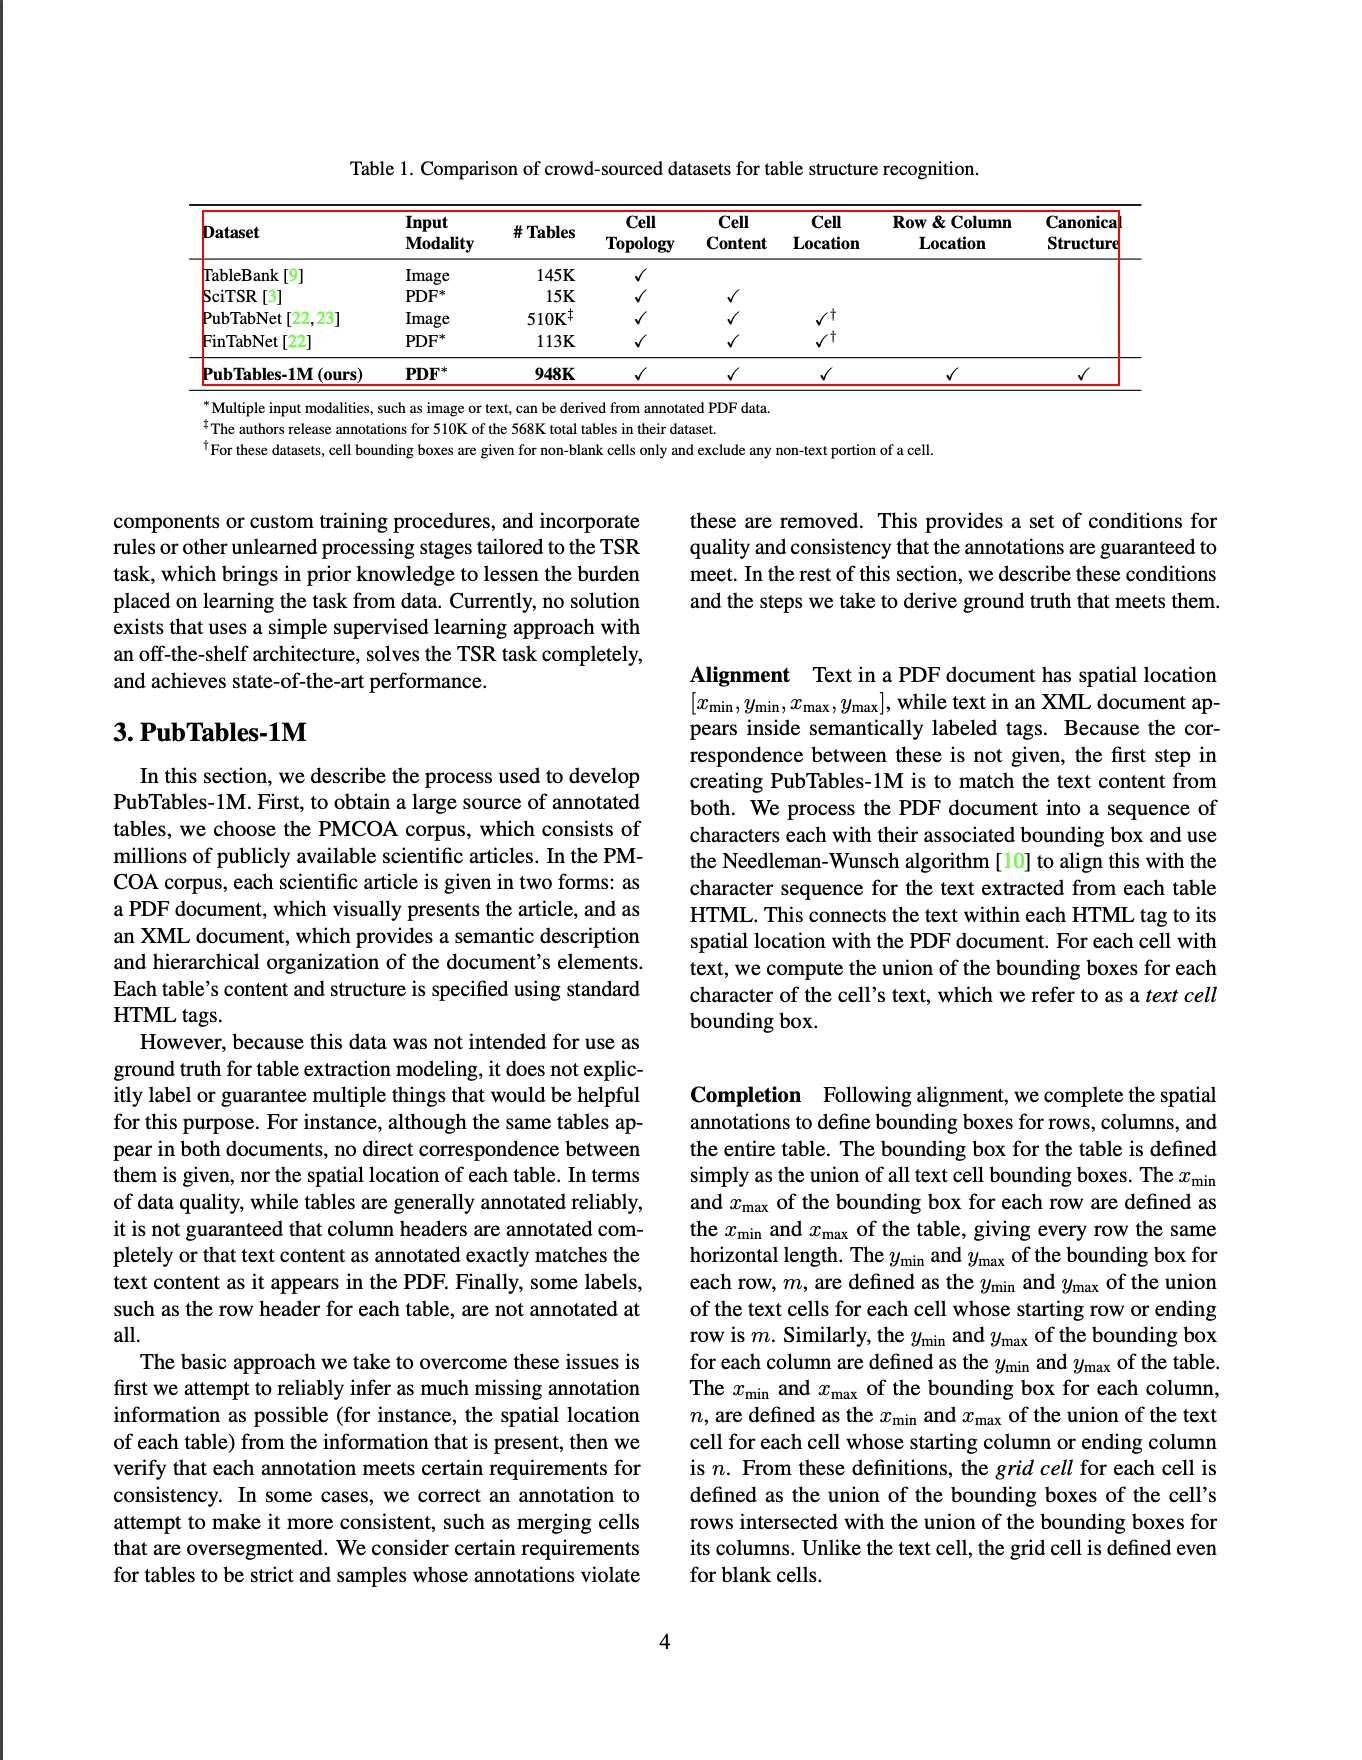

In [19]:
visualize_bbox(image, results["boxes"][0].tolist())

**bold text**## Table structure recognition

What do you understand by table structure recognition?

Definition: Given an image of a table, identifying the rows, columns, and column headers.


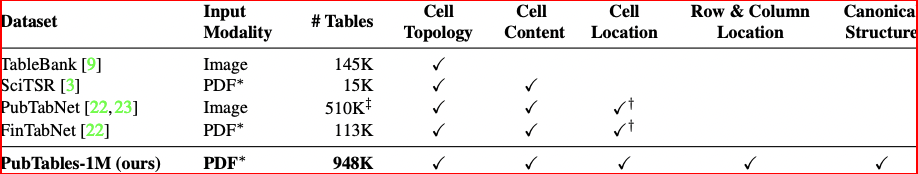

In [20]:
# Let's crop the table image from the page

table_image = image.crop(box)

table_image

What's the problem with the above cropped table? Do you see any issues?

What can we do differently?

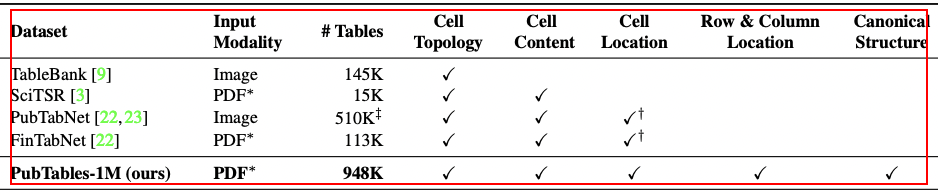

In [21]:
# Let's add some padding to the box so that we don't crop too close to the table.

padding = 10

box = [box[0] - padding, box[1] - padding, box[2] + padding, box[3] + padding]

table_image = image.crop(box)

table_image

Let's now do table structure recognition on the table image.

In [22]:
import matplotlib.pyplot as plt
from transformers import DetrFeatureExtractor, DetrForObjectDetection

In [23]:
COLORS = [
    [0.000, 0.447, 0.741],
    [0.850, 0.325, 0.098],
    [0.929, 0.694, 0.125],
    [0.494, 0.184, 0.556],
    [0.466, 0.674, 0.188],
    [0.301, 0.745, 0.933],
]

def plot_simple_box(table_img, bboxes, file_name="output.png"):
    plt.figure(figsize=(16, 10))
    plt.imshow(table_img)
    ax = plt.gca()
    colors = COLORS * 100
    for bbox, c in zip(bboxes, colors):
        ax.add_patch(
            plt.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                fill=False,
                color=c,
                linewidth=0.5,
            )
        )
    plt.axis("off")
    plt.show()
    plt.savefig(f"{file_name}.png", bbox_inches="tight")




In [24]:
model_structure = TableTransformerForObjectDetection.from_pretrained(
    "microsoft/table-transformer-structure-recognition")


def get_row_col_bounds(table, ts_thresh=0.7, plot=False):
    feature_extractor = DetrFeatureExtractor()
    table_encoding = feature_extractor(table, return_tensors="pt")

    # predict table structure
    with torch.no_grad():
        outputs = model_structure(**table_encoding)

    # visualize table structure
    target_sizes = [table.size[::-1]]
    table_struct_results = feature_extractor.post_process_object_detection(
        outputs, threshold=ts_thresh, target_sizes=target_sizes
    )[0]


    row_boxes = table_struct_results["boxes"][
        table_struct_results["labels"] == model_structure.config.label2id["table row"]
    ]

    row_scores = table_struct_results["scores"][
        table_struct_results["labels"] == model_structure.config.label2id["table row"]
    ]

    col_boxes = table_struct_results["boxes"][
        table_struct_results["labels"]
        == model_structure.config.label2id["table column"]
    ]

    col_scores = table_struct_results["scores"][
        table_struct_results["labels"]
        == model_structure.config.label2id["table column"]
    ]

    table_header_box = table_struct_results["boxes"][
        table_struct_results["labels"]
        == model_structure.config.label2id["table column header"]
    ]
    table_header_score = table_struct_results["scores"][
        table_struct_results["labels"]
        == model_structure.config.label2id["table column header"]
    ]

    print(f"Num rows initially detected: {len(row_boxes)}")
    print(f"Num cols initially detected: {len(col_boxes)}")
    print(f"Num table header detected: {len(table_header_box)}")


    return (
        row_boxes,
        row_scores,
        col_boxes,
        col_scores,
        table_header_box,
        table_header_score,
    )

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
table_structure_outs = get_row_col_bounds(table_image)

Num rows initially detected: 5
Num cols initially detected: 7
Num table header detected: 1


In [26]:
## can you identify each of these components?
table_structure_outs

(tensor([[ 13.8462, 104.8486, 899.6822, 127.7524],
         [ 14.0068,  57.0947, 899.8804,  84.1945],
         [ 13.6592,  82.4375, 899.5753, 105.1078],
         [ 13.6076,  19.7961, 899.6664,  56.6409],
         [ 13.6984, 127.9520, 899.7661, 149.6090]]),
 tensor([0.9939, 0.9389, 0.9875, 0.9520, 0.9873]),
 tensor([[589.1208,  19.6075, 698.7053, 149.6950],
         [501.4056,  19.7475, 589.2468, 149.7181],
         [ 14.5201,  19.9277, 181.8019, 149.6259],
         [695.9993,  19.6024, 839.7112, 149.6203],
         [302.0485,  19.5608, 398.5411, 149.7270],
         [839.7183,  19.4531, 897.4878, 149.5298],
         [181.3766,  19.6560, 300.0316, 149.6975]]),
 tensor([0.9984, 0.9971, 0.9999, 0.9957, 0.9998, 0.9854, 0.9999]),
 tensor([[ 13.4891,  19.8061, 899.7009,  55.9953]]),
 tensor([0.9780]))

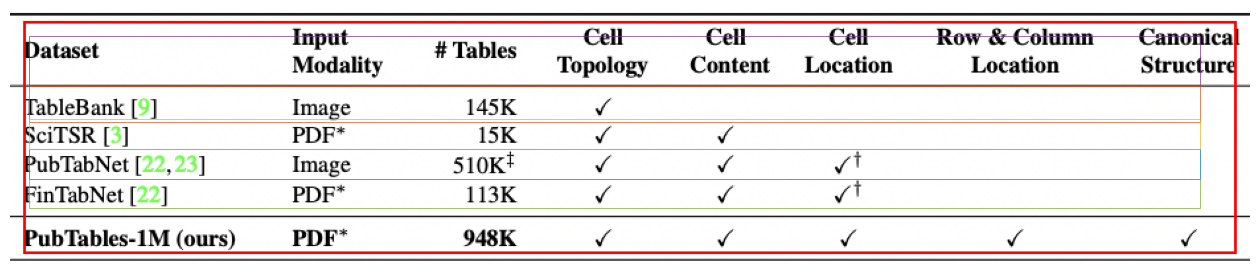

<Figure size 640x480 with 0 Axes>

In [27]:
# Let's visualise the rows first

plot_simple_box(table_image, table_structure_outs[0])

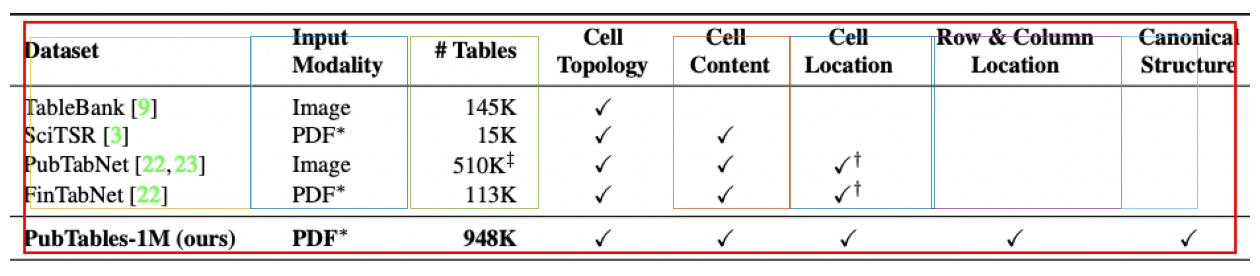

<Figure size 640x480 with 0 Axes>

In [28]:
# Let's visualise the columns

plot_simple_box(table_image, table_structure_outs[2])

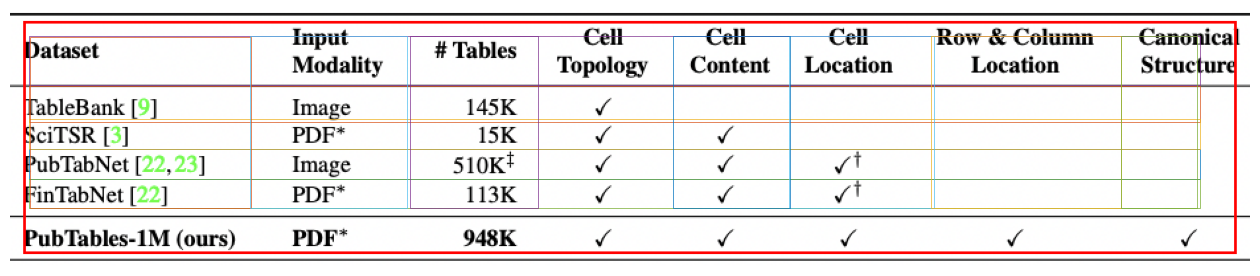

<Figure size 640x480 with 0 Axes>

In [29]:
# Let's visualise rows and columns together

plot_simple_box(table_image, table_structure_outs[0].tolist() + table_structure_outs[2].tolist())

### Issues with table structure recognition

Can you list the issues you see in the above table structure recognition?

### Rerunning the notebook with a 'simpler' table image

In [30]:
# prompt: connect my drive to colab

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
table_image_path = "/content/drive/MyDrive/fin_docs/0081e7fd154bb0319f96ac0c6127da1a-118.png"

In [106]:
table_image = Image.open(table_image_path).convert("RGB")

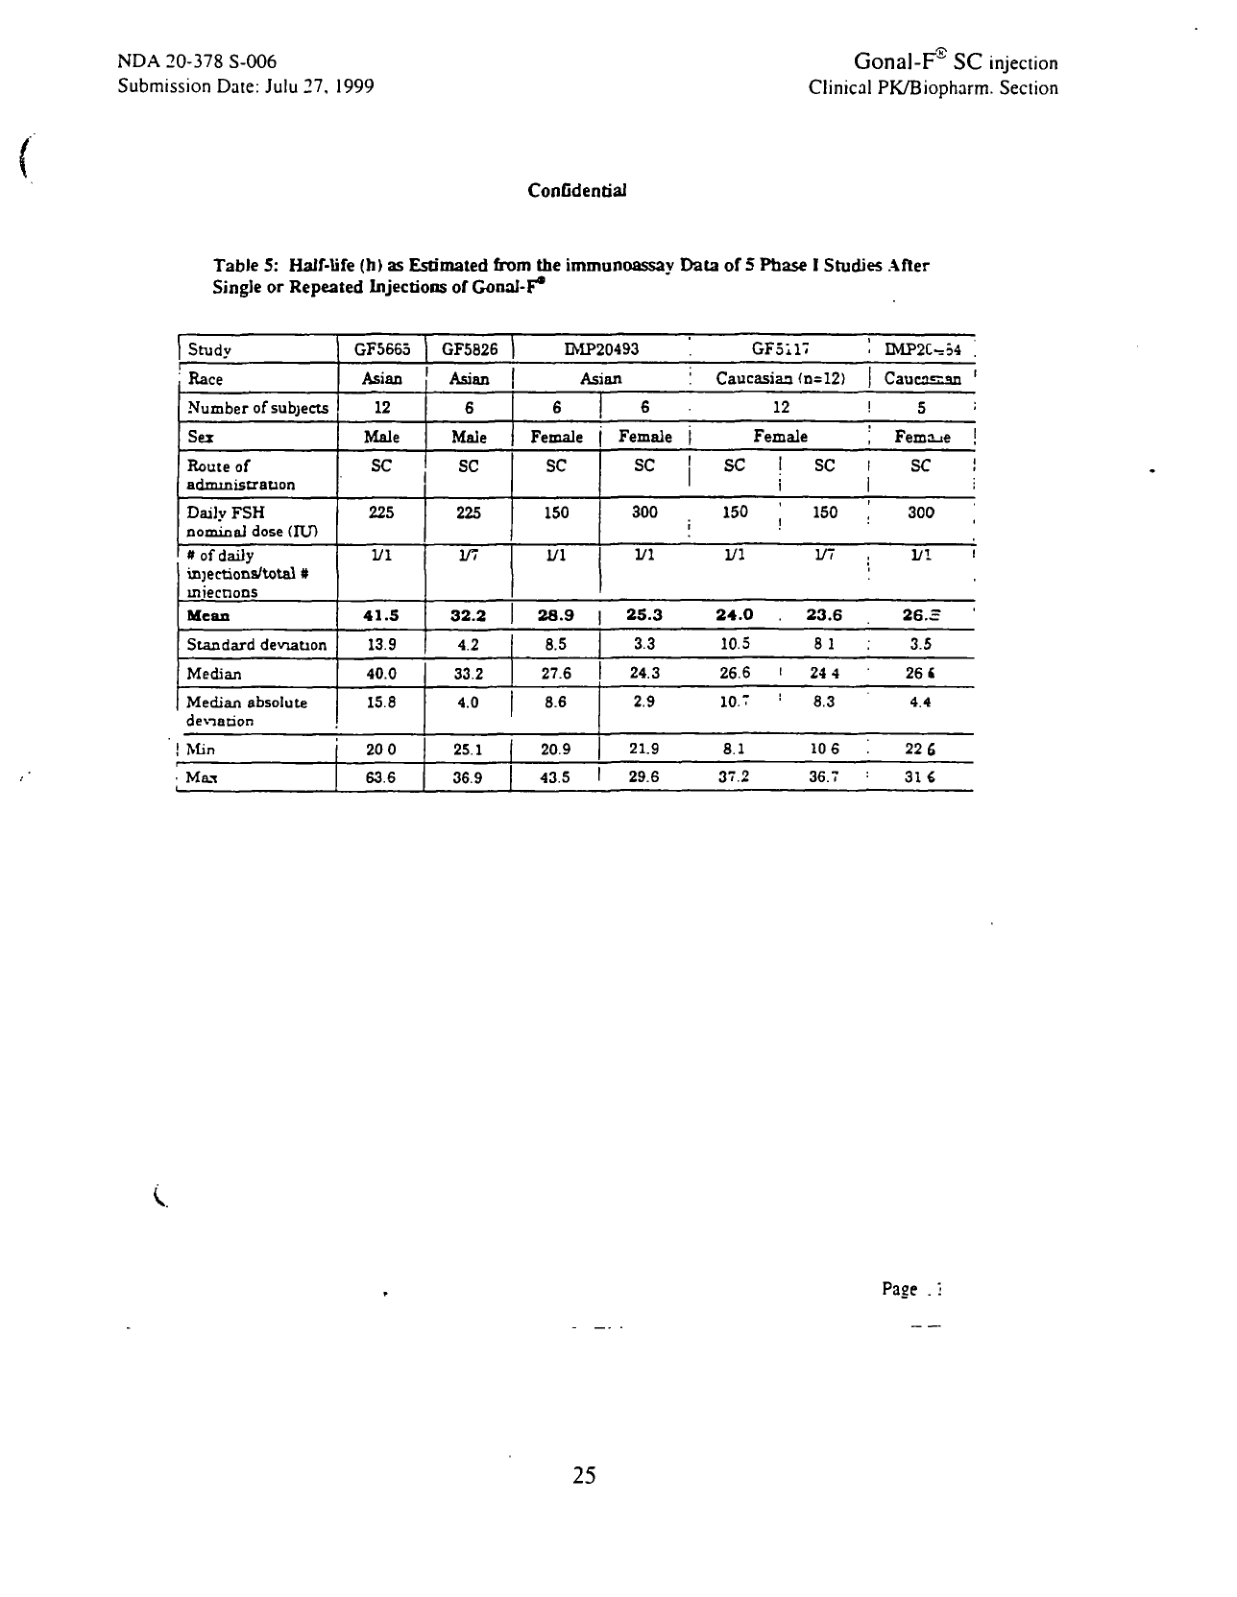

In [107]:
table_image

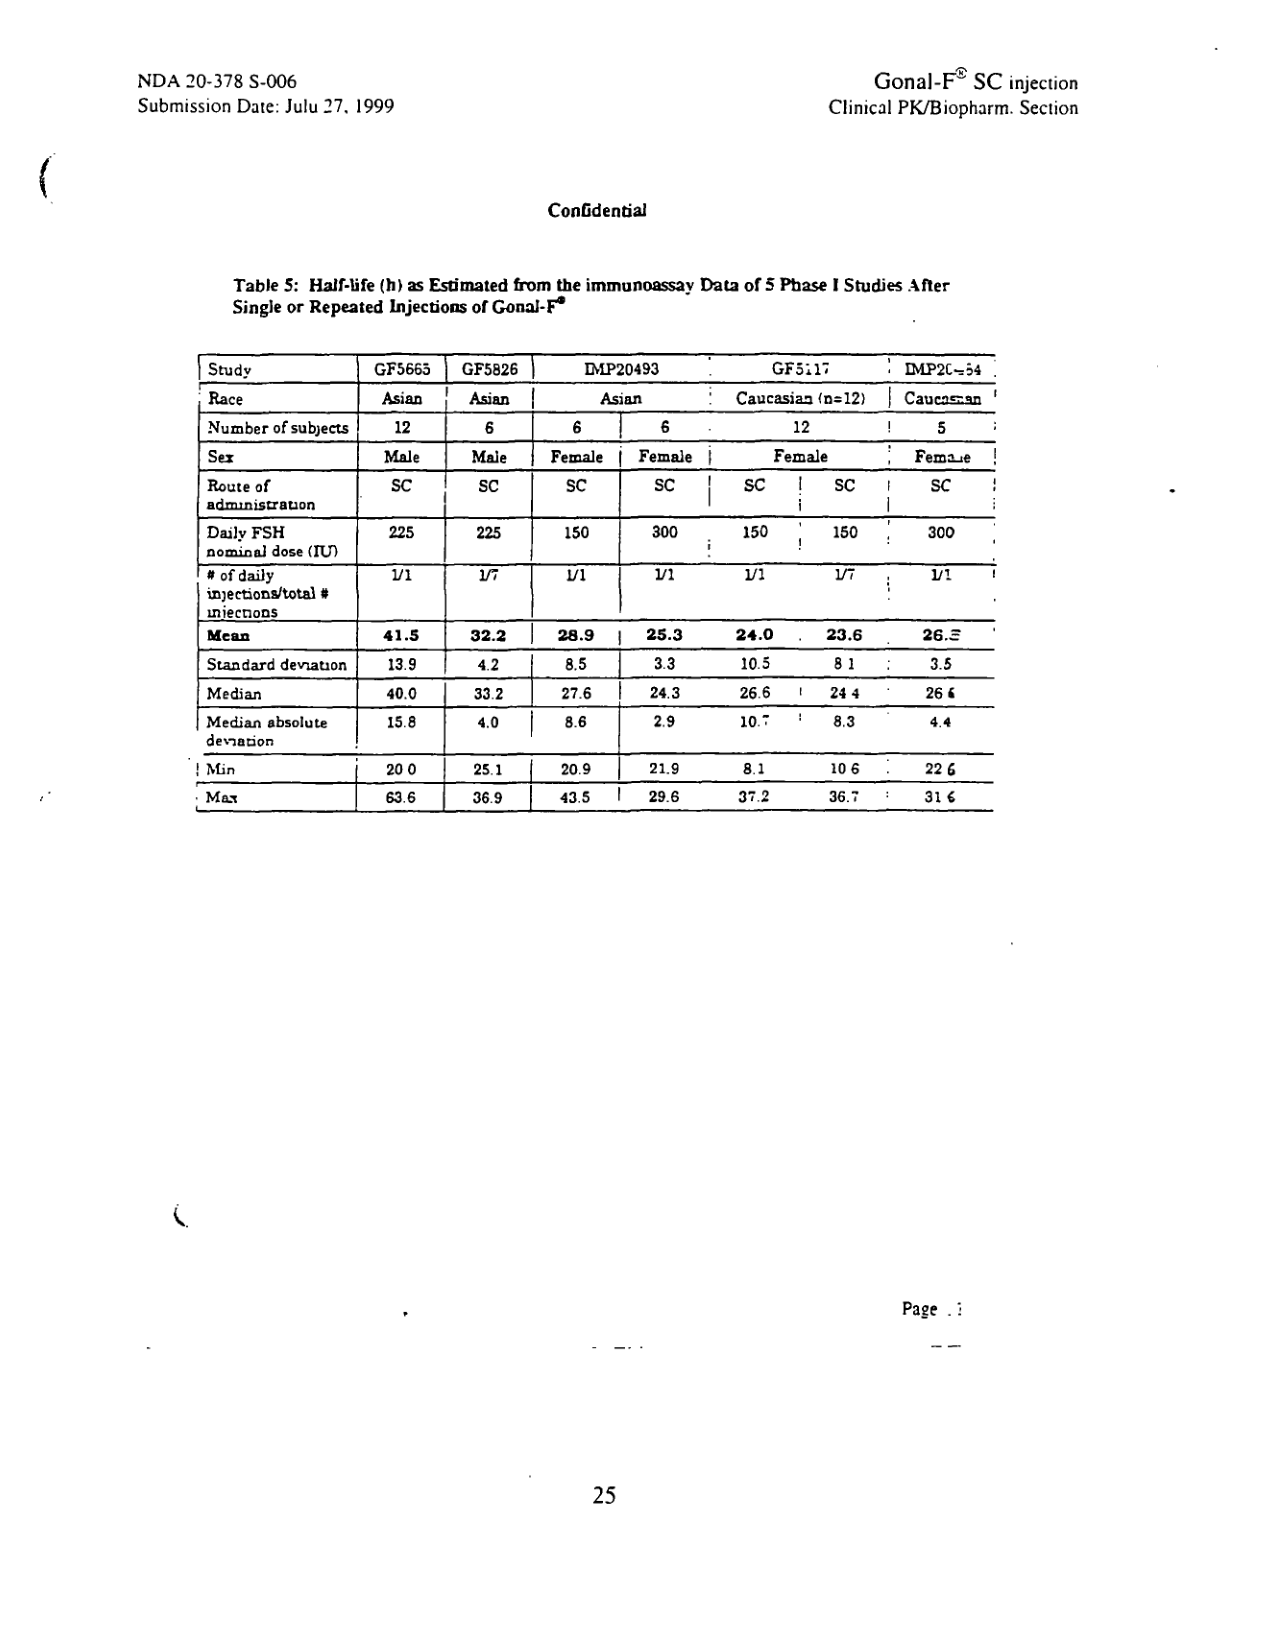

In [108]:
# prompt: add some padding white to PIL image 20 px

from PIL import Image

def add_padding(image, padding_width, color=(255, 255, 255)):
  """Adds padding to a PIL image.

  Args:
    image: The PIL Image object.
    padding_width: The width of the padding in pixels.
    color: The color of the padding (default: white).

  Returns:
    A new PIL Image object with the padding added.
  """
  width, height = image.size
  new_width = width + 2 * padding_width
  new_height = height + 2 * padding_width
  new_image = Image.new(image.mode, (new_width, new_height), color)
  new_image.paste(image, (padding_width, padding_width))
  return new_image


# Example usage
# Assuming you have a PIL image named `table_image`
padded_image = add_padding(table_image, 20)
padded_image # show the image with padding


In [109]:
table_structure_outs = get_row_col_bounds(padded_image)

Num rows initially detected: 26
Num cols initially detected: 13
Num table header detected: 1


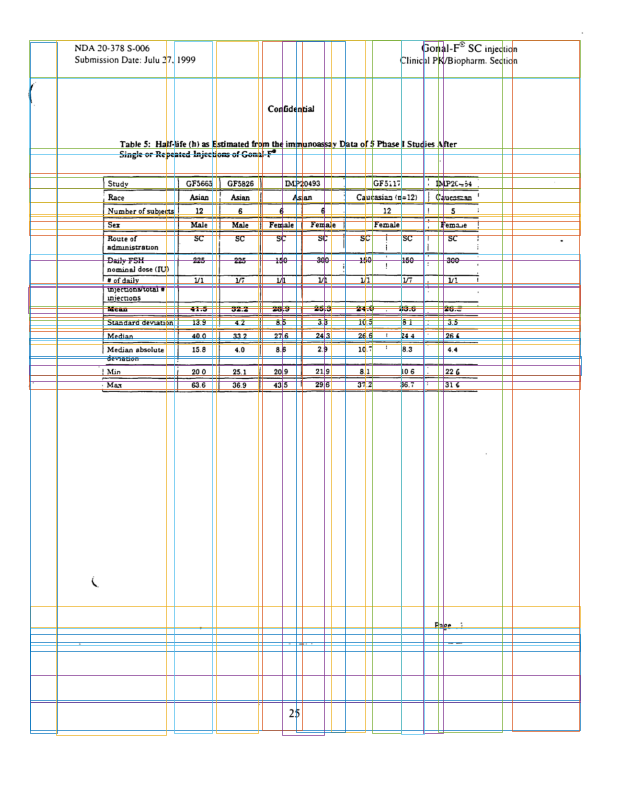

<Figure size 640x480 with 0 Axes>

In [110]:
plot_simple_box(padded_image, table_structure_outs[0].tolist() + table_structure_outs[2].tolist())

Is there a difference between first image and this image in table structure model performance?
What is the difference between the first image and this image which enables this difference?

## Decomposing cells

Can you write a function that takes the table_structure_outs and gives a list of cell bboxes?


In [111]:
def sort_row_col_boxes(row_boxes, col_boxes):
  row_boxes = row_boxes.tolist()
  col_boxes = col_boxes.tolist()
  row_boxes.sort(key=lambda x: x[1])
  col_boxes.sort(key=lambda x: x[0])
  return row_boxes, col_boxes

In [112]:
def get_cells_by_intersecting_rows_and_cols(row_boxes, col_boxes, padding=(0,0)):
  cells = []
  for row_box in row_boxes:
    for col_box in col_boxes:
      cells_left_upper_x = col_box[0]
      cells_left_upper_y = row_box[1]
      cells_right_lower_x = col_box[2]
      cells_right_lower_y = row_box[3]
      cells.append([cells_left_upper_x,
                    cells_left_upper_y,
                    cells_right_lower_x,
                    cells_right_lower_y])
  return cells


In [113]:
sorted_rows, sorted_cols = sort_row_col_boxes(table_structure_outs[0], table_structure_outs[2])

In [114]:
cells = get_cells_by_intersecting_rows_and_cols(sorted_rows, sorted_cols)

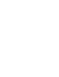

In [115]:
padded_image.crop(cells[0])

## Cells to DataFrame

Now that you have each cell, what do you need to do get a DataFrame of the table with cell values?

In [116]:
%pip install paddlepaddle paddleocr

In [117]:
!rm -rf ~/.paddleocr/

In [47]:
from paddleocr import PaddleOCR

ocr = PaddleOCR(
    lang="en",
    use_gpu=False,
    show_log=False,
)

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 4.00M/4.00M [00:02<00:00, 1.82MiB/s]


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10.2M/10.2M [00:02<00:00, 3.99MiB/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:01<00:00, 1.11MiB/s]


In [118]:
%pip install opencv-python

In [119]:
import cv2
import numpy as np

In [120]:
def PIL_to_cv(pil_img):
  return cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

In [121]:
results=[]
for cell in cells:
  cell_image = padded_image.crop(cell)
  result = ocr.ocr(PIL_to_cv(cell_image))
  results.append(result)


[2024/10/18 15:30:32] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/10/18 15:30:32] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/10/18 15:30:33] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/10/18 15:30:33] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/10/18 15:30:33] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/10/18 15:30:33] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/10/18 15:30:33] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/10/18 15:30:33] ppocr WARNING: Since the angle classifier is not initialized,

In [122]:
%pip install pandas

In [123]:
import pandas as pd

In [124]:
num_rows = len(sorted_rows)
num_cols = len(sorted_cols)

df = pd.DataFrame(index=range(num_rows), columns=range(num_cols))

In [125]:
for i, result in enumerate(results):
  # Check if result is valid and contains the expected data structure
  if result and result[0] and result[0][0] and result[0][0][1]:
    df.iloc[i // num_cols, i % num_cols] = result[0][0][1][0]
  else:
    # Handle the case where result is None or has an unexpected structure
    # You might want to log this, assign a default value, or skip the cell
    print(f"Warning: OCR result for cell {i} is invalid: {result}")
    df.iloc[i // num_cols, i % num_cols] = ""  # Assign an empty string as an example

In [126]:
df

0                   1            2            3         4         5   \
0         NDA20-378 S-006         1999                                    
1              Table 5:Ha  life (h) as  stimated fr  Confiden  Gdential   
2            Singie or Re   ated Injec   ons of Gon      I-F*             
3                   Study       GF5663       GF5826        MP   MP20493   
4                    Race        Asian           --        As     Asian   
5         Number of subje           12            6         6             
6                     Sex         Male         Maie    Female       ale   
7                     Sex         Male         Maie    Female       ale   
8               Daily FSH          225          225       150        30   
9               Daily FSH          225          225       150         V   
10     injections/total #                                                 
11       njections/total#         41.5         32.2      28.9        25   
12                   Mean         41.5         32.2      28.9         9   
13       Standard deviati         13.9          4.2       8.5        3.   
14                 Median         40.0         33.2      27.6         6   
15                 Median         40.0         33.2      27.6        .6   
16        Median absolute         15.8          4.0       8.6             
17               devation          200         25.1      20.9         9   
18                  ! Min         20 0         25.1      20.9         9   
19                    Max         63.6         36.9      43.5         5   
20                                                                        
21                                                                        
22                                                                        
23                                                                        
24                                                                        
25                                                         25        25   

        6         7        8       9       10              11 12  
0                              Clinic    Gona  nal-F SC injec  n  
1   ential  y Data o    Phase  I Stud  lies A           After     
2                                                                 
3   P20493              GF517              IM         MP2C-54     
4     sian        Ca  casiann    =12)       C       Caucasron     
5        6                 12                               5     
6   Female             Female                           Femae     
7   Female             Female                           Femae     
8      300         1        1     150       :             300     
9      300         i        !     150                     300     
10                                                                
11    25.3        24             23.6                     26.     
12    25.3         2             23.6                    26.3     
13     3.3        10               81                     3.5     
14    24.3        26        -     244                     266     
15    24.3         2        -                            26 6     
16     2.9        10              8.3                     4.4     
17    21.9                        106                     226     
18    21.9         8             10 6                    22 6     
19       1        37             36.7                     316     
20                                                                
21                                                                
22                                                                
23                                                                
24                                                                
25

In [127]:
df.colums =df.iloc[0].tolist()
df.drop(df.index[0], inplace=True)

In [128]:
df

0                   1            2            3         4         5   \
1              Table 5:Ha  life (h) as  stimated fr  Confiden  Gdential   
2            Singie or Re   ated Injec   ons of Gon      I-F*             
3                   Study       GF5663       GF5826        MP   MP20493   
4                    Race        Asian           --        As     Asian   
5         Number of subje           12            6         6             
6                     Sex         Male         Maie    Female       ale   
7                     Sex         Male         Maie    Female       ale   
8               Daily FSH          225          225       150        30   
9               Daily FSH          225          225       150         V   
10     injections/total #                                                 
11       njections/total#         41.5         32.2      28.9        25   
12                   Mean         41.5         32.2      28.9         9   
13       Standard deviati         13.9          4.2       8.5        3.   
14                 Median         40.0         33.2      27.6         6   
15                 Median         40.0         33.2      27.6        .6   
16        Median absolute         15.8          4.0       8.6             
17               devation          200         25.1      20.9         9   
18                  ! Min         20 0         25.1      20.9         9   
19                    Max         63.6         36.9      43.5         5   
20                                                                        
21                                                                        
22                                                                        
23                                                                        
24                                                                        
25                                                         25        25   

        6         7        8       9       10         11 12  
1   ential  y Data o    Phase  I Stud  lies A      After     
2                                                            
3   P20493              GF517              IM    MP2C-54     
4     sian        Ca  casiann    =12)       C  Caucasron     
5        6                 12                          5     
6   Female             Female                      Femae     
7   Female             Female                      Femae     
8      300         1        1     150       :        300     
9      300         i        !     150                300     
10                                                           
11    25.3        24             23.6                26.     
12    25.3         2             23.6               26.3     
13     3.3        10               81                3.5     
14    24.3        26        -     244                266     
15    24.3         2        -                       26 6     
16     2.9        10              8.3                4.4     
17    21.9                        106                226     
18    21.9         8             10 6               22 6     
19       1        37             36.7                316     
20                                                           
21                                                           
22                                                           
23                                                           
24                                                           
25

In [129]:
df.iloc[-1].tolist()

['', '', '', '', '25', '25', '', '', '', '', '', '', '']

In [130]:
df.columns

RangeIndex(start=0, stop=13, step=1)

In [131]:
df.colums =df.iloc[0].tolist()
df.drop(df.index[0], inplace=True)

In [132]:
df

0                   1           2           3       4        5       6   \
2            Singie or Re  ated Injec  ons of Gon    I-F*                    
3                   Study      GF5663      GF5826      MP  MP20493  P20493   
4                    Race       Asian          --      As    Asian    sian   
5         Number of subje          12           6       6                6   
6                     Sex        Male        Maie  Female      ale  Female   
7                     Sex        Male        Maie  Female      ale  Female   
8               Daily FSH         225         225     150       30     300   
9               Daily FSH         225         225     150        V     300   
10     injections/total #                                                    
11       njections/total#        41.5        32.2    28.9       25    25.3   
12                   Mean        41.5        32.2    28.9        9    25.3   
13       Standard deviati        13.9         4.2     8.5       3.     3.3   
14                 Median        40.0        33.2    27.6        6    24.3   
15                 Median        40.0        33.2    27.6       .6    24.3   
16        Median absolute        15.8         4.0     8.6              2.9   
17               devation         200        25.1    20.9        9    21.9   
18                  ! Min        20 0        25.1    20.9        9    21.9   
19                    Max        63.6        36.9    43.5        5       1   
20                                                                           
21                                                                           
22                                                                           
23                                                                           
24                                                                           
25                                                     25       25           

    7        8     9   10         11 12  
2                                        
3         GF517        IM    MP2C-54     
4   Ca  casiann  =12)   C  Caucasron     
5            12                    5     
6        Female                Femae     
7        Female                Femae     
8    1        1   150   :        300     
9    i        !   150            300     
10                                       
11  24           23.6            26.     
12   2           23.6           26.3     
13  10             81            3.5     
14  26        -   244            266     
15   2        -                 26 6     
16  10            8.3            4.4     
17                106            226     
18   8           10 6           22 6     
19  37           36.7            316     
20                                       
21                                       
22                                       
23                                       
24                                       
25

In [133]:
df.iloc[-1].tolist()

['', '', '', '', '25', '25', '', '', '', '', '', '', '']

In [134]:
df.columns

RangeIndex(start=0, stop=13, step=1)

In [135]:
df = df.iloc[1:]

In [136]:
df

0                   1       2       3       4        5       6   7   \
3                   Study  GF5663  GF5826      MP  MP20493  P20493       
4                    Race   Asian      --      As    Asian    sian  Ca   
5         Number of subje      12       6       6                6       
6                     Sex    Male    Maie  Female      ale  Female       
7                     Sex    Male    Maie  Female      ale  Female       
8               Daily FSH     225     225     150       30     300   1   
9               Daily FSH     225     225     150        V     300   i   
10     injections/total #                                                
11       njections/total#    41.5    32.2    28.9       25    25.3  24   
12                   Mean    41.5    32.2    28.9        9    25.3   2   
13       Standard deviati    13.9     4.2     8.5       3.     3.3  10   
14                 Median    40.0    33.2    27.6        6    24.3  26   
15                 Median    40.0    33.2    27.6       .6    24.3   2   
16        Median absolute    15.8     4.0     8.6              2.9  10   
17               devation     200    25.1    20.9        9    21.9       
18                  ! Min    20 0    25.1    20.9        9    21.9   8   
19                    Max    63.6    36.9    43.5        5       1  37   
20                                                                       
21                                                                       
22                                                                       
23                                                                       
24                                                                       
25                                             25       25               

         8     9   10         11 12  
3     GF517        IM    MP2C-54     
4   casiann  =12)   C  Caucasron     
5        12                    5     
6    Female                Femae     
7    Female                Femae     
8         1   150   :        300     
9         !   150            300     
10                                   
11           23.6            26.     
12           23.6           26.3     
13             81            3.5     
14        -   244            266     
15        -                 26 6     
16            8.3            4.4     
17            106            226     
18           10 6           22 6     
19           36.7            316     
20                                   
21                                   
22                                   
23                                   
24                                   
25

In [138]:
df.to_csv("/content/drive/MyDrive/fin_docs/table.csv", index=False)